In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt


random.seed(42)

In [2]:
class TicTacToeEnvironment:
    def __init__(self):
        self.board = [' ' for _ in range(9)]  # Empty board with 9 spaces
        self.agent_symbol = 'X'  # Agent is always 'X'
        self.opponent_symbol = 'O'  # Opponent is always 'O'
        self.current_player = random.choice([self.agent_symbol, self.opponent_symbol])  # Randomize who starts

    def print_board(self):
        print(f"{self.board[0]} | {self.board[1]} | {self.board[2]}")
        print("-" * 5)
        print(f"{self.board[3]} | {self.board[4]} | {self.board[5]}")
        print("-" * 5)
        print(f"{self.board[6]} | {self.board[7]} | {self.board[8]}")

    def is_valid_move(self, position):
        return 0 <= position < 9 and self.board[position] == ' '

    def act(self, position, player):
        if self.is_valid_move(position):
            self.board[position] = player
            self.switch_player()
        else:
            raise ValueError("Invalid move! Position already occupied or out of bounds.")

    def switch_player(self):
        self.current_player = self.opponent_symbol if self.current_player == self.agent_symbol else self.agent_symbol

    def check_winner(self):
        winning_combinations = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]  # Diagonals
        ]
        for combo in winning_combinations:
            if self.board[combo[0]] == self.board[combo[1]] == self.board[combo[2]] and self.board[combo[0]] != ' ':
                return self.board[combo[0]]  # Return 'X' or 'O' as the winner
        if ' ' not in self.board:
            return 'draw'  # Draw
        return None  # Game continues

    def available_moves(self):
        """
        Returns a list of available (empty) positions on the board.
        """
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def reset(self):
        self.board = [' ' for _ in range(9)]
        self.current_player = random.choice([self.agent_symbol, self.opponent_symbol])

    def is_winning_move(self, player, position):
        """
        Checks if placing the player's symbol in the given position results in a win.
        Temporarily place the symbol and then check if the player wins.
        """
        self.board[position] = player
        is_win = self.check_winner() == player
        self.board[position] = ' '  # Undo the move
        return is_win

class RandomAgent:
    def __init__(self, agent_symbol):
        self.agent_symbol = agent_symbol

    def make_move(self, env):
        """
        The random agent picks a move randomly from available positions.
        """
        available_moves = env.available_moves()
        return random.choice(available_moves) if available_moves else None

class SafeAgent:
    def __init__(self, agent_symbol, opponent_symbol):
        self.agent_symbol = agent_symbol  # Symbol for the safe agent ('O' for opponent)
        self.opponent_symbol = opponent_symbol  # Symbol for the opponent ('X' for Q-learning agent)

    def make_move(self, env):
        """
        The safe agent first looks for a winning move, then a blocking move,
        otherwise selects a move randomly.
        """
        available_moves = env.available_moves()

        # Look for a winning move
        for move in available_moves:
            if env.is_winning_move(self.agent_symbol, move):
                return move

        # Look for a blocking move
        for move in available_moves:
            if env.is_winning_move(self.opponent_symbol, move):
                return move

        # If no winning or blocking move, pick randomly
        return random.choice(available_moves) if available_moves else None


In [3]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, agent_symbol='X'):
        self.q_table = defaultdict(lambda: np.zeros(9))  # Q-values for each state (board) and action (move)
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.agent_symbol = agent_symbol  # 'X' for the Q-learning agent, 'O' for opponents

    def get_state(self, env):
        """
        Returns a tuple representation of the current board state.
        This will be used as the state for Q-learning.
        """
        return tuple(env.board)

    def choose_action(self, state, env):
        """
        Choose an action using epsilon-greedy strategy.
        """
        if random.uniform(0, 1) < self.epsilon:
            # Explore: pick a random available move
            return random.choice(env.available_moves())
        else:
            # Exploit: pick the best known move based on Q-values
            q_values = self.q_table[state]
            available_moves = env.available_moves()
            best_action = max(available_moves, key=lambda x: q_values[x])
            return best_action

    def update_q_table(self, state, action, reward, next_state):
        """
        Update Q-values using the Q-learning formula.
        """
        best_next_action = np.argmax(self.q_table[next_state])  # Greedy action for next state
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def play_move(self, env):
        """
        Make a move using the epsilon-greedy policy.
        """
        state = self.get_state(env)
        action = self.choose_action(state, env)
        env.act(action, 'X')  # Agent plays 'X'
        return state, action

    def greedy_action(self, state, env):
        """
        Choose the best action based on the Q-table (fully greedy, no exploration).
        """
        q_values = self.q_table[state]
        available_moves = env.available_moves()
        return max(available_moves, key=lambda x: q_values[x])

# Reward function
def get_reward(winner, agent_symbol):
    if winner == agent_symbol:
        return 1  # Win
    elif winner == 'draw':
        return 0.5  # Draw
    else:
        return -1  # Loss

# Train Q-learning agent against random player
def train_q_learning_agent_random(epochs=10000, evaluate_every=200):
    env = TicTacToeEnvironment()
    agent = QLearningAgent()
    random_opponent = RandomAgent('O')

    win_record = []
    evaluation_points = []

    for epoch in range(epochs):
        env.reset()
        while True:
            if env.current_player == agent.agent_symbol:
                state, action = agent.play_move(env)  # Agent's turn
                winner = env.check_winner()
                if winner is not None:
                    reward = get_reward(winner, agent.agent_symbol)
                    agent.update_q_table(state, action, reward, agent.get_state(env))
                    break
                else:
                    next_state = agent.get_state(env)
                    agent.update_q_table(state, action, 0, next_state)
            else:
                # Random opponent plays 'O'
                move = random_opponent.make_move(env)
                env.act(move, 'O')
                if env.check_winner() is not None:
                    break

        # Every `evaluate_every` games, play 100 test games and assess the agent's performance
        if (epoch + 1) % evaluate_every == 0:
            wins = evaluate_agent(agent, random_opponent)
            win_record.append(wins)
            evaluation_points.append(epoch + 1)  # Track the number of games played

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_points, win_record, marker='o', color='b', label='Wins in 100 games')
    plt.xlabel("Number of training games")
    plt.ylabel("Number of wins in 100 test games")
    plt.title("Q-learning Agent Training Progress")
    plt.grid(True)
    plt.legend()
    plt.show()

    return agent


# Train Q-learning agent against safe player
def train_q_learning_agent_safe(epochs=10000, evaluate_every=200):
    env = TicTacToeEnvironment()
    agent = QLearningAgent()
    safe_opponent = SafeAgent('O','X')

    win_record = []
    evaluation_points = []

    for epoch in range(epochs):
        env.reset()
        while True:
            if env.current_player == agent.agent_symbol:
                state, action = agent.play_move(env)  # Agent's turn
                winner = env.check_winner()
                if winner is not None:
                    reward = get_reward(winner, agent.agent_symbol)
                    agent.update_q_table(state, action, reward, agent.get_state(env))
                    break
                else:
                    next_state = agent.get_state(env)
                    agent.update_q_table(state, action, 0, next_state)
            else:
                # Random opponent plays 'O'
                move = safe_opponent.make_move(env)
                env.act(move, 'O')
                if env.check_winner() is not None:
                    break

        # Every `evaluate_every` games, play 100 test games and assess the agent's performance
        if (epoch + 1) % evaluate_every == 0:
            wins = evaluate_agent(agent, random_opponent)
            win_record.append(wins)
            evaluation_points.append(epoch + 1)  # Track the number of games played

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_points, win_record, marker='o', color='b', label='Wins in 100 games')
    plt.xlabel("Number of training games")
    plt.ylabel("Number of wins in 100 test games")
    plt.title("Q-learning Agent Training Progress")
    plt.grid(True)
    plt.legend()
    plt.show()

    return agent


# Function to train Q-learning agent against randomly selected opponents
def train_q_learning_agent_mixed(epochs=10000, evaluate_every=200):
    env = TicTacToeEnvironment()
    agent = QLearningAgent()

    # Opponents
    random_opponent = RandomAgent('O')
    safe_opponent = SafeAgent('O', 'X')

    # Records to track the number of wins in evaluation against both types of opponents
    random_win_record = []
    safe_win_record = []
    evaluation_points = []

    for epoch in range(epochs):
        env.reset()
        
        # Randomly select the opponent (random or safe)
        opponent = random.choice([random_opponent, safe_opponent])

        while True:
            if env.current_player == agent.agent_symbol:
                state, action = agent.play_move(env)  # Agent's turn
                winner = env.check_winner()
                if winner is not None:
                    reward = get_reward(winner, agent.agent_symbol)
                    agent.update_q_table(state, action, reward, agent.get_state(env))
                    break
                else:
                    next_state = agent.get_state(env)
                    agent.update_q_table(state, action, 0, next_state)
            else:
                # Selected opponent plays 'O'
                move = opponent.make_move(env)
                env.act(move, 'O')
                if env.check_winner() is not None:
                    break

        # Every `evaluate_every` games, play 100 test games against both random and safe opponents
        if (epoch + 1) % evaluate_every == 0:
            # Evaluate against random opponent using greedy policy
            random_wins = evaluate_agent(agent, random_opponent)
            random_win_record.append(random_wins)
            
            # Evaluate against safe opponent using greedy policy
            safe_wins = evaluate_agent(agent, safe_opponent)
            safe_win_record.append(safe_wins)
            
            # Record the number of games played for the x-axis
            evaluation_points.append(epoch + 1)

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_points, random_win_record, marker='o', color='b', label='Wins vs Random in 100 games')
    plt.plot(evaluation_points, safe_win_record, marker='o', color='r', label='Wins vs Safe in 100 games')
    plt.xlabel("Number of training games")
    plt.ylabel("Number of wins in 100 test games")
    plt.title("Q-learning Agent Training Progress vs Random and Safe Opponents")
    plt.grid(True)
    plt.legend()
    plt.show()

    return agent


# Evaluate the agent's performance by playing 100 games with greedy policy
def evaluate_agent(agent, opponent, num_games=100):
    wins = 0
    for _ in range(num_games):
        env = TicTacToeEnvironment()
        while True:
            if env.current_player == agent.agent_symbol:
                state = agent.get_state(env)
                move = agent.greedy_action(state, env)  # Fully greedy
                env.act(move, 'X')
            else:
                move = opponent.make_move(env)
                env.act(move, 'O')

            winner = env.check_winner()
            if winner is not None:
                if winner == 'X':
                    wins += 1
                break

    return wins

# Final testing of the trained agent against both random and safe opponents
def test_trained_agent(agent, random_opponent, safe_opponent, num_games=1000):
    for opponent in [random_opponent, safe_opponent]:
        results = {'wins': 0, 'draws': 0, 'losses': 0}
        if opponent==random_opponent:
            print("Test Results for Random Opponent")
        if opponent==safe_opponent:
            print("Test Results for Safe Opponent")
        for _ in range(num_games):
            env = TicTacToeEnvironment()
            while True:
                if env.current_player == agent.agent_symbol:
                    state = agent.get_state(env)
                    move = agent.greedy_action(state, env)  # Fully greedy
                    env.act(move, 'X')
                else:
                    move = opponent.make_move(env)
                    env.act(move, 'O')

                winner = env.check_winner()
                if winner is not None:
                    if winner == 'X':
                        results['wins'] += 1
                    elif winner == 'draw':
                        results['draws'] += 1
                    else:
                        results['losses'] += 1
                    break

        print(f"Performance: {results['wins']} wins, {results['draws']} draws, {results['losses']} losses")


# Training Against Random Agent

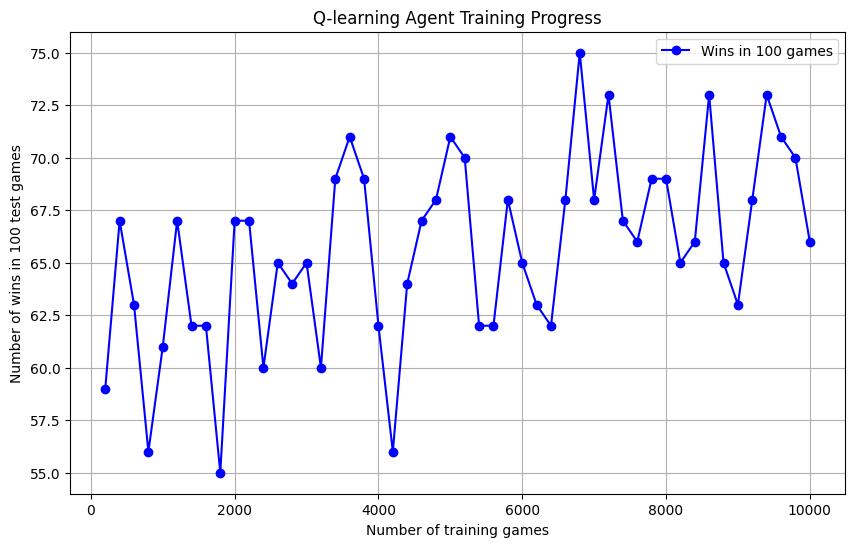

Test Results for Random Opponent
Performance: 701 wins, 31 draws, 268 losses
Test Results for Safe Opponent
Performance: 35 wins, 120 draws, 845 losses


In [4]:
# 1. Train the Q-learning agent and generate the training progress plot
test_trained_agent_random = train_q_learning_agent_random(epochs=10000, evaluate_every=200)


# 2. Define the opponents (Random and Safe Agents)
random_opponent = RandomAgent('O')
safe_opponent = SafeAgent('O', 'X')

# 3. Test the trained agent's performance after training
test_trained_agent(test_trained_agent_random, random_opponent, safe_opponent, num_games=1000)


# Training Against Safe Agent

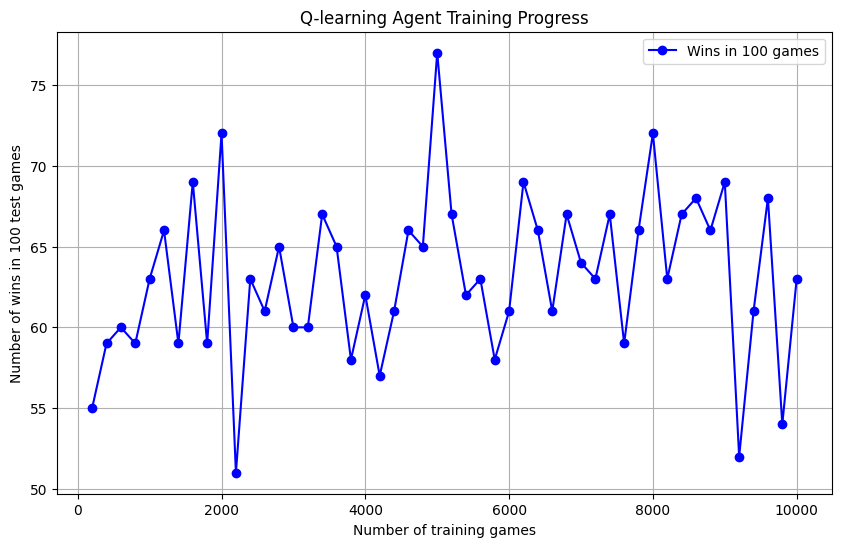

Test Results for Random Opponent
Performance: 639 wins, 34 draws, 327 losses
Test Results for Safe Opponent
Performance: 121 wins, 12 draws, 867 losses


In [5]:

# 1. Train the Q-learning agent and generate the training progress plot
trained_agent_safe = train_q_learning_agent_safe(epochs=10000, evaluate_every=200)


# 2. Define the opponents (Random and Safe Agents)
random_opponent = RandomAgent('O')
safe_opponent = SafeAgent('O', 'X')

# 3. Test the trained agent's performance after training
test_trained_agent(trained_agent_safe, random_opponent, safe_opponent, num_games=1000)

# Training Against Mixed(Random and Safe Both)

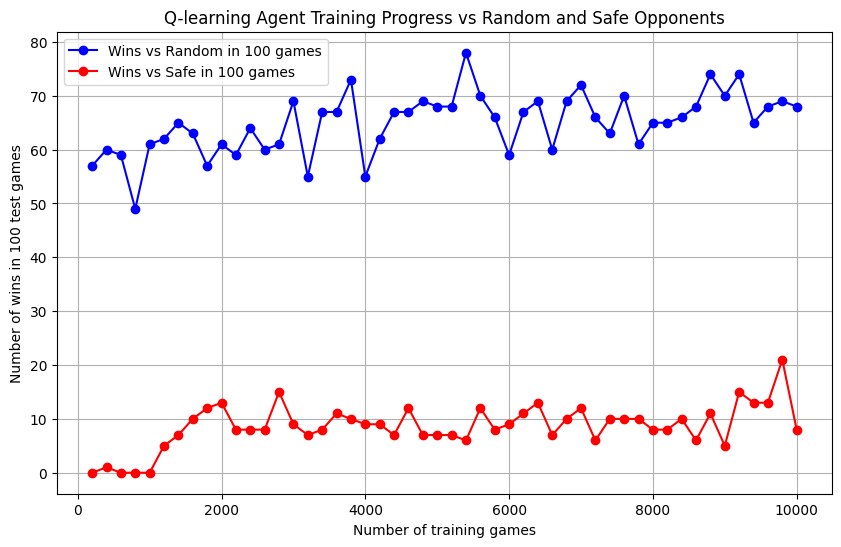

Test Results for Random Opponent
Performance: 695 wins, 36 draws, 269 losses
Test Results for Safe Opponent
Performance: 105 wins, 33 draws, 862 losses


In [6]:
# 1. Train the Q-learning agent and generate the training progress plot
test_trained_agent_mixed = train_q_learning_agent_mixed(epochs=10000, evaluate_every=200)


# 2. Define the opponents (Random and Safe Agents)
random_opponent = RandomAgent('O')
safe_opponent = SafeAgent('O', 'X')

# 3. Test the trained agent's performance after training
test_trained_agent(test_trained_agent_mixed, random_opponent, safe_opponent, num_games=1000)


# Q2(c) 4. Among the three agents developed, which agent is best ? Why ?

|               | Training with Random |                  | Training with Safe |                  | Training with Hybrid |                  |
|---------------|----------------------|------------------|--------------------|------------------|----------------------|------------------|
|               | Random               | Safe             | Random             | Safe             | Random               | Safe             |
| Wins          | 701                  | 35               | 711                | 141              | 695                  | 105              |
| Draw          | 31                   | 120              | 90                 | 12               | 36                   | 33               |
| Losses        | 268                  | 845              | 199                | 847              | 269                  | 862              |
| Total Rewards | 448.5                | -750             | 557                | -700             | 444                  | -740.5          |


Above are the results observed when the results are trained for 10K epochs,
**Training with Safe agent** appears to be the best overall agent due to its highest number of wins, relatively fewer losses in the Random training scenario, and superior total rewards in that same category.
It happens primarily as it encapsulates the greedy behaviour and thereby takes the most opimal action as per the given state.

# Q2(d) Is the Q-learning agent developed unbeatable against any possible opponent ? If not, suggest ways to improve the training process

Q-learning agents are not inherently unbeatable against all possible opponents. 

**Reasons Why Q-Learning Agents Are Not Unbeatable**

1. Q-learning relies on exploration to discover the best strategies. If the agent doesn't explore enough, it may miss optimal actions or strategies that could improve its performance against certain opponents.
2. Q-learning might not converge to the optimal policy in complex environments, especially with function approximation or when using deep Q-learning methods.


**Suggestions to Improve the Training Process**
1. Implementing advanced exploration strategies, such as epsilon-greedy with decaying epsilon
2. Use adaptive learning rates to stabilize learning and enhance convergence, especially in environments with changing dynamics.
3. Combine multiple Q-learning agents (ensemble methods) to create a more robust agent that can leverage the strengths of each individual agent.
